1. First load the dataset.

Note: In SARIMAX, Seasonal AutoRegressive Moving Average with Exogeneous Variable.
Autoregressive is checked by PACF(p),Integrated (d) which is changed by non-stationarity, Moving Average is checked by ACF(q), .

In [10]:
import pandas as pd 

import matplotlib.pyplot as plt
df = pd.read_csv("KiranaPasal_Data.csv")

In [11]:
df.info(),
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                730 non-null    object 
 1   Sales               730 non-null    int64  
 2   Festival_Indicator  730 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.2+ KB


,Date,Sales,Festival_Indicator
0,2081-01-01,23904,0.0
1,2081-01-02,31138,0.0
2,2081-01-03,19682,0.0
3,2081-01-04,20632,0.0
4,2081-01-05,18692,0.0


2. Preprocessing -> Converting the Data column to a datetime format.

In [12]:
df["Date"] = pd.to_datetime(df["Date"])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                730 non-null    datetime64[ns]
 1   Sales               730 non-null    int64         
 2   Festival_Indicator  730 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 17.2 KB


,Date,Sales,Festival_Indicator
0,2081-01-01,23904,0.0
1,2081-01-02,31138,0.0
2,2081-01-03,19682,0.0
3,2081-01-04,20632,0.0
4,2081-01-05,18692,0.0


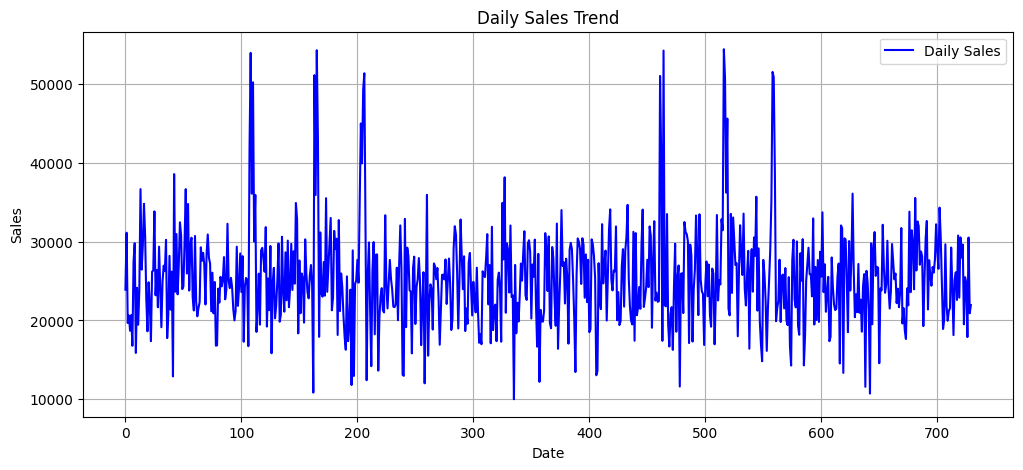

In [13]:

plt.figure(figsize=(12, 5))
plt.plot(df['Sales'], label='Daily Sales', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Trend')
plt.legend()
plt.grid()
plt.show()

3. Stationarity check and differencing,<br> 
i. We need to check whether the time series is stationary or not using Augmented Dickey Fuller Test. <br\>
Let's first learn why we are checking stationarity and what is stationarity??<br>
Stationary have mean and variance same. There is not much drastic change in between values,<br>
<br>
*Note : Mean change -> if every week gets warmer and warmer (e.g., next week’s average becomes 35°C, then 40°C), then it’s not stationary ,trend is increasing.<br>
Variance change -> If one day the temperature is 30°C and the next day it suddenly jumps to 100°C 🌋, and then to -50°C 🧊, then it’s not stationary .*<br>

And I just got to know,<br> 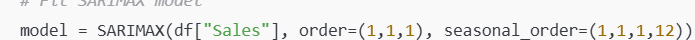<br>
SARIMAX can work with non-stationary data because it includes differencing to transform the data into stationary form. 
If ADF test gives p-value > 0.05, apply first-order differencing (d=1).
Subtracting past value with present value.



Why do we check for stationarity if SARIMAX can make data stationary internally?<br>
i. To determine the right differencing, if data is stationary set d=0,<br>
ii. If data is already stationary then , if we don't check we might introduce unnecessary fluctuations.<br>
iii. If the series is non-stationary but becomes stationary after a single difference then we can also use ARIMA.<br>


Ways to check stationarity:
i. Plot the data,
ii. ACF and PACF plots
iii. Augmented Dickey Fuller Test

Mathematically,
The ADF test checks for a unit root to determine this.

A unit root means the series doesn’t “return to a stable mean.” If there is a unit root, the series is non-stationary.

The number of unit roots is the same as the number of differencing operations needed to make the series stationary.


In [14]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Sales'])
adf_statistic, p_value, _, _, critical_values, _ = adf_test
{
    "ADF Statistic": adf_statistic,
    "p-value": p_value,
    "Critical Values": critical_values
}

{'ADF Statistic': -11.714293632861649,
 'p-value': 1.4637535944274788e-21,
 'Critical Values': {'1%': -3.4393893552577723,
  '5%': -2.8655292671104644,
  '10%': -2.5688943376666744}}

Okay, p value is relatively zero so, the data is already stationary <br >
p< 0.05, the data is stationary and p> 0.05 , the data is non stationary.

What if the data is non-stationary what would we do?
As we know its integrsted so we <br>
we compute the difference between consecutive observations.<br>
df['Sales_diff'] = df['Sales'] - df['Sales'].shift(1)
if seasonal subtract by 7 if weekly,
log transformation can stabilize the variance in time series.

Now, lets learn about autocorrelation and Partial Autocorrelation,


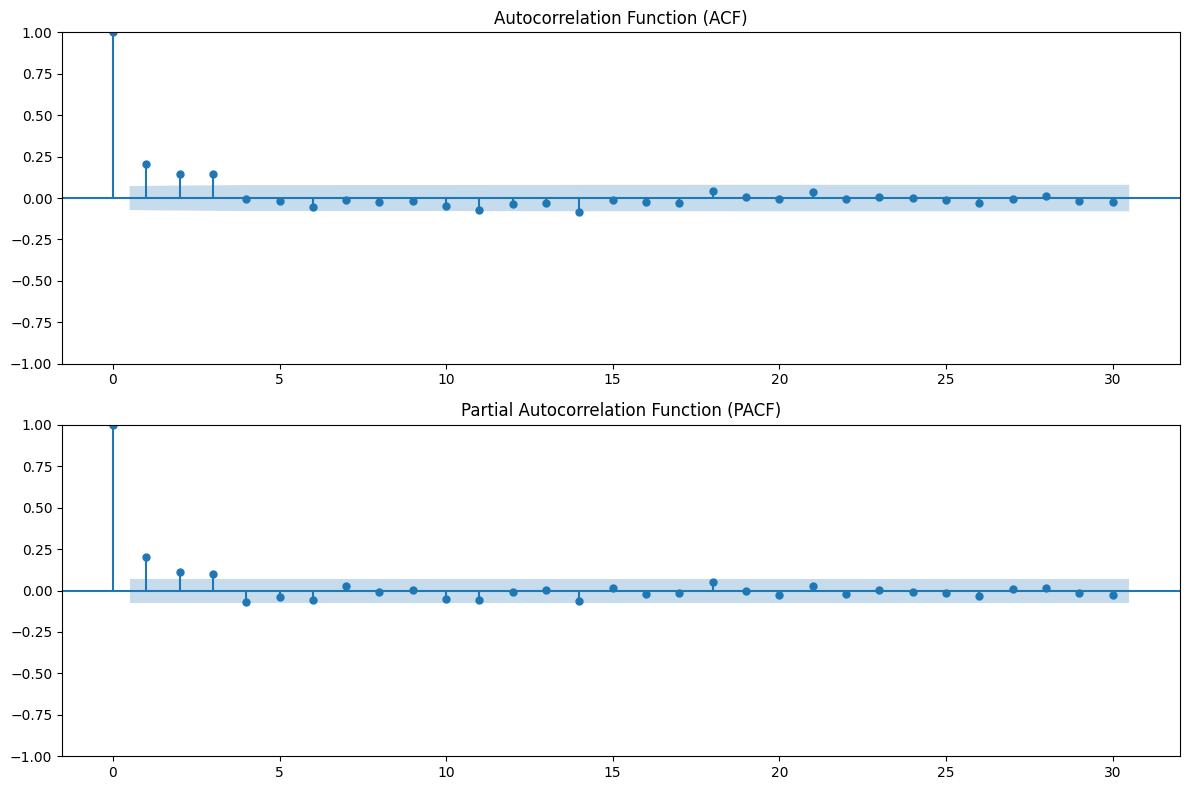

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['Sales'], ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(df['Sales'], ax=ax[1], lags=30)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

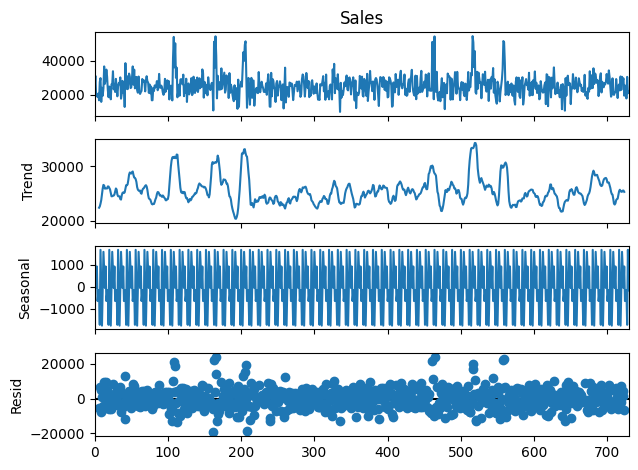

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["Sales"], period=12)  # Change period based on your dataset
result.plot()
plt.show()


Step 2: Identify SARIMAX Parameters
SARIMAX has two main components:

Non-Seasonal ARIMA (p, d, q):
p (AutoRegressive lags) → Use PACF to decide.
d (Differencing order) → Use ADF test to check stationarity.
q (Moving Average lags) → Use ACF to decide.
Seasonal Component (P, D, Q, S):
P (Seasonal AR lags) → Use PACF for seasonality.
D (Seasonal differencing) → If strong seasonality exists, differencing might be needed.
Q (Seasonal MA lags) → Use ACF for seasonality.
S (Seasonal cycle) → E.g., 7 for weekly, 12 for monthly seasonality.


Okay let's understand the ACF , 
ACF checks how much the present value helps in predicting the future values from last values let's say lag is 1 then, the today value is dependent upon yesterday value. This is Autocorrelation Function.

Whereas, in autocorrelation function If PACF shows a strong correlation at lag 1 but not at lag 2, it means that the first lag has a direct impact on today's sales, while the second lag doesn't contribute much after accounting for the first lag.

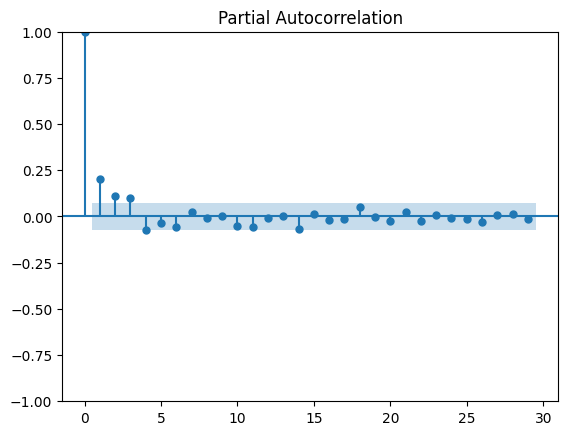

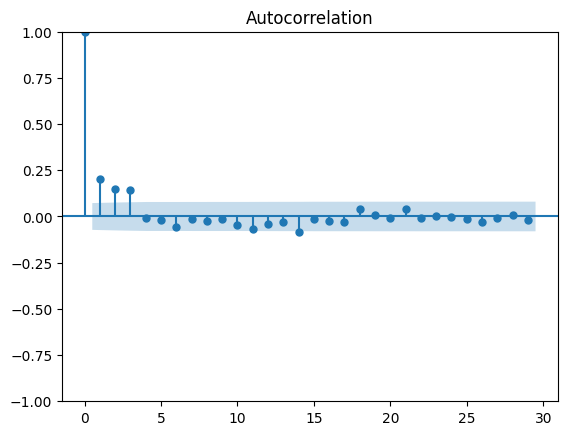

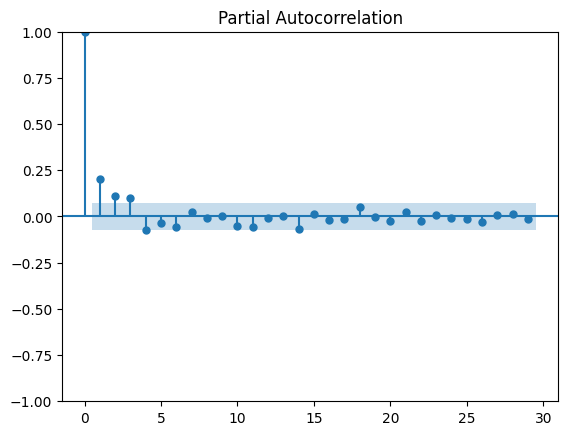

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Sales'])  # No 'lags' parameter, defaults to an optimal choice
plot_pacf(df['Sales'])  


In [7]:

# Define train-test split ratio (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Print shapes of train and test sets
train.shape, test.shape

((584, 3), (146, 3))

y ¬ f(log1, log2y, )

ACF is the correlation of y or of its own series with its own lags, PACF is filtered version of ACF,
learn what is correlation then?
p = 1 or 2 (from PACF cutoff)
d = 1 (if the series is non-stationary; check with a stationarity test like Augmented Dickey-Fuller)
q = 0 or 1 (since ACF gradually declines, indicating weak MA effects)